##  Onboarding Stage
This notebook demonstrates what happens when you call `scripts/extract_template_descriptors.py`.

Make sure you have completed the setup instructions in `README.md` before running this notebook. Run the notebook from the cnos25 repo root directory.

In [2]:
import os
import logging
import hydra
from src.model.descriptor.template_extraction import DinoTemplateExtraction
from src.utils.imgproc import pilImageRow

### Loading the configuration from `extract_templates.yaml`
This is done automatically when you call `scripts/extract_template_descriptors.py`.

In [3]:
config_dir = os.path.abspath("./configs")

with hydra.initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = hydra.compose(config_name="extract_templates", overrides=["dataset_name=handal"])

### Instantiation of dataloader and template_extraction object

In [4]:
# Instantiate the reference dataloader (the one that provides the crops from the onboarding images)
ref_dataloader = hydra.utils.instantiate(cfg.data.reference_dataloader)

In [5]:
# Instantiate the object that handles the template descriptor extraction and saving
template_extraction = DinoTemplateExtraction(descriptor_model=cfg.descriptor_model,
                                            ref_dataloader=ref_dataloader,
                                            obj_names=cfg.data.datasets[cfg.dataset_name].obj_names,
                                            dataset_name=cfg.dataset_name)

### Extract the cropped and masked template images for each object
This may take a while, so reduce the number of images per object to 6 only

In [6]:
ref_dataloader.num_imgs_per_obj = 6

And start extraction...

In [7]:
template_extraction.set_ref_images()

100%|█████████████| 6/6 [00:00<00:00,  6.03it/s]


### The extracted crops are stored in a dict named ref_images:

In [8]:
template_extraction.ref_images.keys()

dict_keys(['hammer_01', 'hammer_blue_02', 'hammer_yellow', 'hammer_black_04', 'hammer_red_05', 'hammer_red_06', 'hammer_blue_07', 'hammer_08', 'hammer_black_09', 'spatula_green_10', 'spatula_red_11', 'spatula_green_12', 'spatula_pink', 'ladle_pink', 'ladle_ghost', 'ladle_blue', 'ladle_yellow', 'ladle_white', 'ladle_orange', 'power_drill_by_20', 'power_drill_by_21', 'power_drill_oran_22', 'power_drill_oran_23', 'power_drill_red_24', 'power_drill_red_25', 'spatula_purple', 'spatula_magenta', 'spatula_oran', 'spatula_cyan', 'strainer_small', 'strainer_long', 'strainer_lgreen', 'strainer_blue', 'strainer_plastic', 'whisk_wood', 'whisk_black_36', 'whisk_green', 'whisk_black_38', 'whisk_red', 'whisk_yellow'])

### Let's view them!

hammer_01                hammer_blue_02


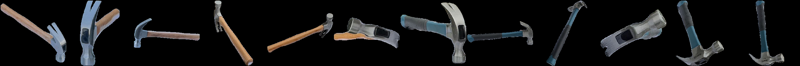

hammer_yellow                hammer_black_04


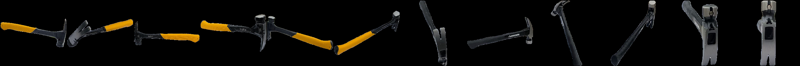

hammer_red_05                hammer_red_06


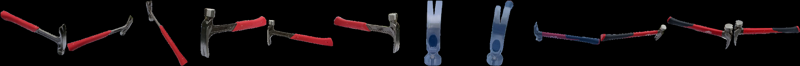

hammer_blue_07                hammer_08


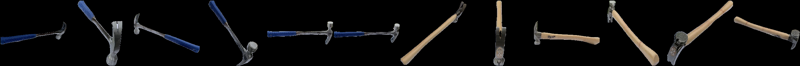

hammer_black_09                spatula_green_10


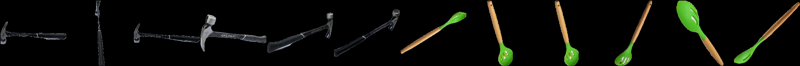

spatula_red_11                spatula_green_12


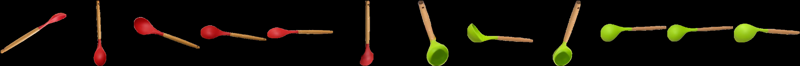

spatula_pink                ladle_pink


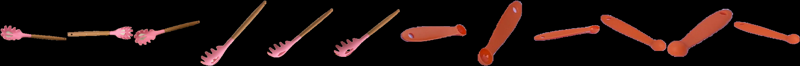

ladle_ghost                ladle_blue


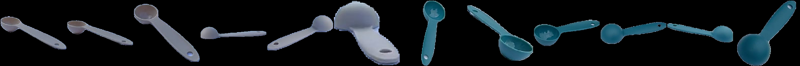

ladle_yellow                ladle_white


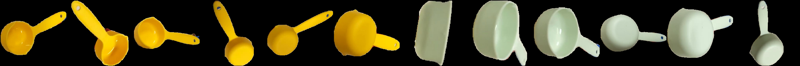

ladle_orange                power_drill_by_20


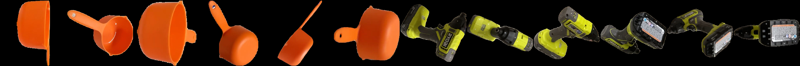

power_drill_by_21                power_drill_oran_22


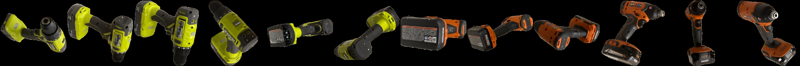

power_drill_oran_23                power_drill_red_24


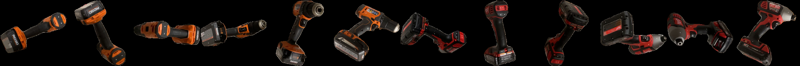

power_drill_red_25                spatula_purple


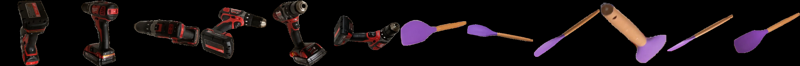

spatula_magenta                spatula_oran


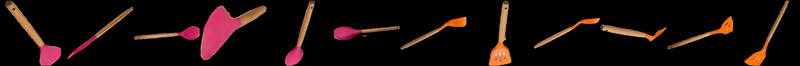

spatula_cyan                strainer_small


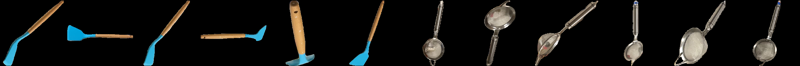

strainer_long                strainer_lgreen


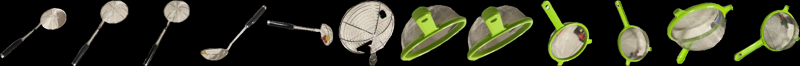

strainer_blue                strainer_plastic


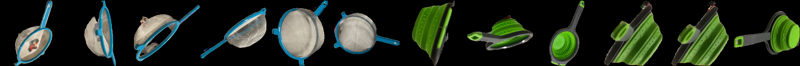

whisk_wood                whisk_black_36


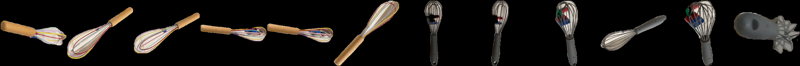

whisk_green                whisk_black_38


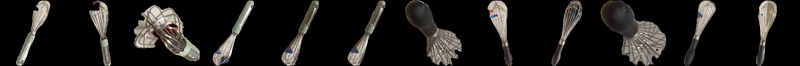

whisk_red                whisk_yellow


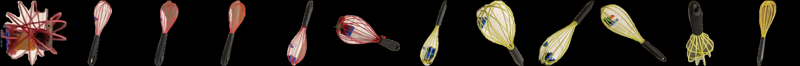

In [9]:
def overview():
    keys = list(template_extraction.ref_images.keys())
    for i in range(len(keys)):
        if i%2!=0:continue
        _next=[]
        if i+1 < len(keys):
            print(keys[i], '              ', keys[i+1])
            _next = template_extraction.ref_images[keys[i+1]]
        else:  print(keys[i])
        display(pilImageRow(*template_extraction.ref_images[keys[i]],*_next))

overview()

Nice.

### Forward each crop through dinov3 to get their descriptors:

In [10]:
# Forward pass through the descriptor model to get descriptors
template_extraction.calc_ref_embs()

Computing template descriptors ...: 100%|█| 40/4


They're stored in ref_descriptors. Let's view the first 4 of them:

In [19]:
{(i,key,descriptor.shape) for i, (key,descriptor) in enumerate(template_extraction.ref_descriptors.items()) if i < 4}

{(0, 'x_norm_clstoken_hammer_01', torch.Size([6, 1024])),
 (1, 'x_norm_patchtokens_hammer_01', torch.Size([6, 196, 1024])),
 (2, 'x_norm_clstoken_hammer_blue_02', torch.Size([6, 1024])),
 (3, 'x_norm_patchtokens_hammer_blue_02', torch.Size([6, 196, 1024]))}

### We have the template descriptors. We're done!
But let's don't forget to save them:

In [12]:
 # Save descriptors dict to a .pt
template_extraction.save(out_file='demo.pt', overwrite=True)

100%|██████████| 80/80 [00:00<00:00, 988.34it/s]


### And finally check if we've done alright

In [13]:
logging.basicConfig(level=logging.DEBUG, force=True)

template_extraction.check_saved('demo.pt')

INFO:root:opening /mnt/external/datasets/bop/handal/onboarding_static/descriptors/demo.pt of size 241.9M
INFO:root:entries in saved file: {'template_embeds': 80, 'template_imgs': 40, 'template_masks': 40}
